In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

In [4]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "alpaca_dataset/"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


In [6]:
train_dataset.class_names

['alpaca', 'not alpaca']

In [7]:
validation_dataset.class_names

['alpaca', 'not alpaca']

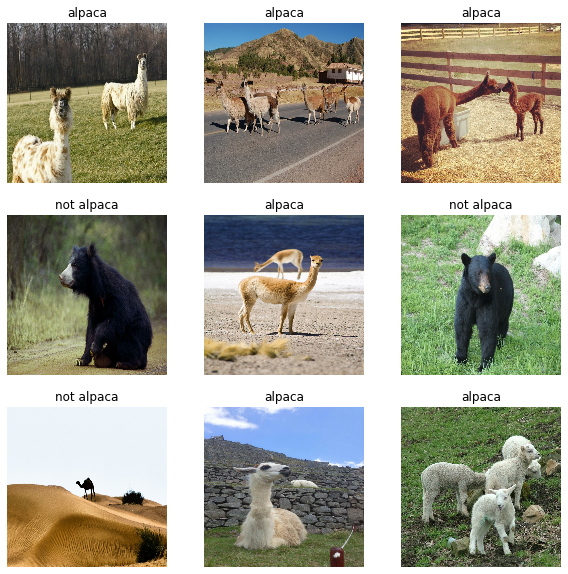

In [5]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Using `prefetch()` prevents a memory bottleneck that can occur when reading from disk. It sets aside some data and keeps it ready for when it's needed, by creating a source dataset from your input data, applying a transformation to preprocess it, then iterating over the dataset one element at a time. Because the iteration is streaming, the data doesn't need to fit into memory.

You can set the number of elements to prefetch manually, or you can use `tf.data.experimental.AUTOTUNE` to choose the parameters automatically. Autotune prompts `tf.data` to tune that value dynamically at runtime, by tracking the time spent in each operation and feeding those times into an optimization algorithm. The optimization algorithm tries to find the best allocation of its CPU budget across all tunable operations. 

To increase diversity in the training set and help your model learn the data better, it's standard practice to augment the images by transforming them, i.e., randomly flipping and rotating them. Keras' Sequential API offers a straightforward method for these kinds of data augmentations, with built-in, customizable preprocessing layers. These layers are saved with the rest of your model and can be re-used later.  Ahh, so convenient! 

As always, you're invited to read the official docs, which you can find for data augmentation [here](https://www.tensorflow.org/tutorials/images/data_augmentation).

In [8]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [10]:
train_dataset

<PrefetchDataset shapes: ((None, 160, 160, 3), (None,)), types: (tf.float32, tf.int32)>

### data_augmenter

Implementing a function for data augmentation. Use a `Sequential` keras model composed of 2 layers:
* `RandomFlip('horizontal')`
* `RandomRotation(0.2)`

In [11]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))
    
    
    return data_augmentation

Take a look at how the images have been augmented

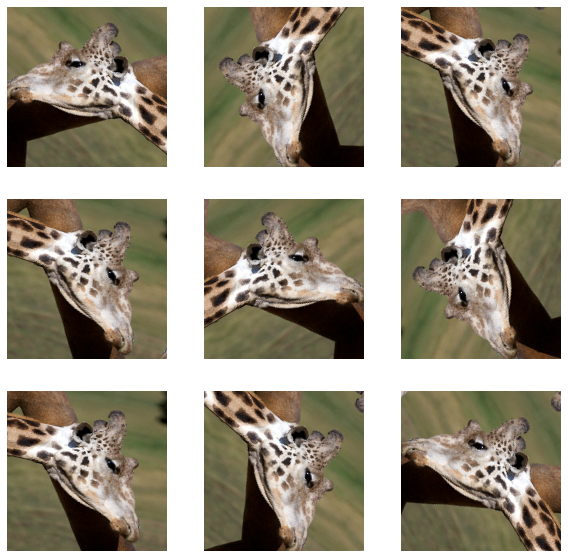

In [12]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

Next, you'll apply your first tool from the MobileNet application in TensorFlow, to normalize your input. Since you're using a pre-trained model that was trained on the normalization values [-1,1], it's best practice to reuse that standard with tf.keras.applications.mobilenet_v2.preprocess_input.

**What you should remember:**

* When calling image_data_set_from_directory(), specify the train/val subsets and match the seeds to prevent overlap
* Use prefetch() to prevent memory bottlenecks when reading from disk
* Give your model more to learn from with simple data augmentations like rotation and flipping.
* When using a pretrained model, it's best to reuse the weights it was trained on.

In [13]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [14]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

14548992/14536120 [==============================] - 2s 0us/step


In [15]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [18]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)
# Printing the name of the last two layers
# These layers are responsible for the classification

global_average_pooling2d
predictions


Next, choose the first batch from the tensorflow dataset to use the images, and run it through the MobileNetV2 base model to test out the predictions on some of your images. 

In [19]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


In [20]:
#Shows the different label probabilities in one tensor 
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0])>

In [21]:
base_model.trainable = False
image_var = tf.Variable(image_batch)
pred = base_model(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

49152/35363 [=========================================] - 0s 0us/step


[[('n04589890', 'window_screen', 0.42582303),
  ('n02708093', 'analog_clock', 0.09275514)],
 [('n04589890', 'window_screen', 0.2398593),
  ('n03887697', 'paper_towel', 0.14802621)],
 [('n04589890', 'window_screen', 0.74494606),
  ('n03598930', 'jigsaw_puzzle', 0.021948533)],
 [('n04589890', 'window_screen', 0.3354598),
  ('n03530642', 'honeycomb', 0.07628956)],
 [('n04589890', 'window_screen', 0.27327433),
  ('n03733281', 'maze', 0.08846927)],
 [('n04589890', 'window_screen', 0.67452353),
  ('n03530642', 'honeycomb', 0.076598845)],
 [('n04589890', 'window_screen', 0.7912856),
  ('n04209239', 'shower_curtain', 0.09241608)],
 [('n04589890', 'window_screen', 0.16463025),
  ('n03598930', 'jigsaw_puzzle', 0.087491065)],
 [('n03598930', 'jigsaw_puzzle', 0.37021348),
  ('n04589890', 'window_screen', 0.09956956)],
 [('n04589890', 'window_screen', 0.6161646),
  ('n03887697', 'paper_towel', 0.054876737)],
 [('n03530642', 'honeycomb', 0.254489),
  ('n04589890', 'window_screen', 0.24874318)],
 [('

In the next sections, you'll see how you can use a pretrained model to modify the classifier task so that it's able to recognize alpacas. You can achieve this in three steps: 

1. Delete the top layer (the classification layer)
    * Set `include_top` in `base_model` as False
2. Add a new classifier layer
    * Train only one layer by freezing the rest of the network
    * As mentioned before, a single neuron is enough to solve a binary classification problem.
3. Freeze the base model and train the newly-created classifier layer
    * Set `base model.trainable=False` to avoid changing the weights and train *only* the new layer
    * Set training in `base_model` to False to avoid keeping track of statistics in the batch norm layer

### alpaca_model

In [23]:
def alpaca_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    
    
    input_shape = image_shape + (3,)
    
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights='imagenet') # From imageNet
    
    # freeze the base model by making it non trainable
    base_model.trainable = False

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    x = data_augmentation(inputs)
    
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x) 
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = tfl.GlobalAveragePooling2D()(x) 
    # include dropout with probability of 0.2 to avoid overfitting
    x = tfl.Dropout(0.2)(x)
        
    # use a prediction layer with one neuron (as a binary classifier only needs one)
    prediction_layer = tfl.Dense(1) 
    outputs = prediction_layer(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

Create your new model using the data_augmentation function defined earlier.

In [24]:
model2 = alpaca_model(IMG_SIZE, data_augmentation)

9420800/9406464 [==============================] - 2s 0us/step


In [26]:
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
9/9 [==============================] - 6s 456ms/step - loss: 0.7515 - accuracy: 0.5229 - val_loss: 0.5552 - val_accuracy: 0.6154
Epoch 2/5
9/9 [==============================] - 4s 388ms/step - loss: 0.5754 - accuracy: 0.6450 - val_loss: 0.4199 - val_accuracy: 0.6923
Epoch 3/5
9/9 [==============================] - 4s 391ms/step - loss: 0.4970 - accuracy: 0.7824 - val_loss: 0.3655 - val_accuracy: 0.7385
Epoch 4/5
9/9 [==============================] - 4s 388ms/step - loss: 0.4602 - accuracy: 0.7214 - val_loss: 0.3529 - val_accuracy: 0.7538
Epoch 5/5
9/9 [==============================] - 4s 374ms/step - loss: 0.3588 - accuracy: 0.8206 - val_loss: 0.2779 - val_accuracy: 0.8154


Plot the training and validation accuracy:

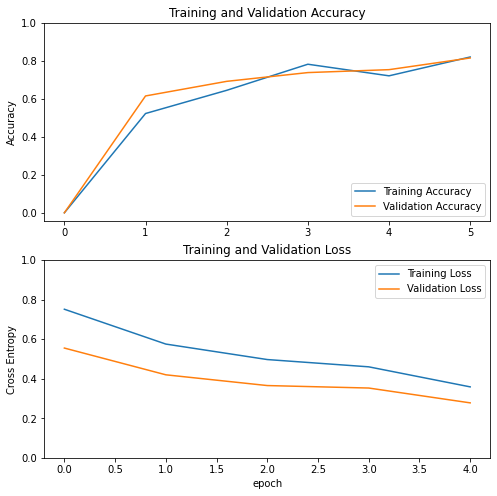

In [28]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

The results are ok, but could be better. Next, try some fine-tuning.

### Fine-Tuning

You could try fine-tuning the model by re-running the optimizer in the last layers to improve accuracy. When you use a smaller learning rate, you take smaller steps to adapt it a little more closely to the new data. In transfer learning, the way you achieve this is by unfreezing the layers at the end of the network, and then re-training your model on the final layers with a very low learning rate. Adapting your learning rate to go over these layers in smaller steps can yield more fine details - and higher accuracy.

The intuition for what's happening: when the network is in its earlier stages, it trains on low-level features, like edges. In the later layers, more complex, high-level features like wispy hair or pointy ears begin to emerge. For transfer learning, the low-level features can be kept the same, as they have common features for most images. When you add new data, you generally want the high-level features to adapt to it, which is rather like letting the network learn to detect features more related to your data, such as soft fur or big teeth. 

To achieve this, just unfreeze the final layers and re-run the optimizer with a smaller learning rate, while keeping all the other layers frozen.

Where the final layers actually begin is a bit arbitrary, so feel free to play around with this number a bit. The important takeaway is that the later layers are the part of your network that contain the fine details (pointy ears, hairy tails) that are more specific to your problem.

First, unfreeze the base model by setting `base_model.trainable=True`, set a layer to fine-tune from, then re-freeze all the layers before it. Run it again for another few epochs, and see if your accuracy improved!

In [29]:
base_model = model2.layers[4]
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function=tf.keras.losses.BinaryCrossentropy(from_logits=True)
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate*0.1)
# Use accuracy as evaluation metric
metrics=['accuracy']

model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

Number of layers in the base model:  154


In [30]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/10
9/9 [==============================] - 7s 521ms/step - loss: 0.5774 - accuracy: 0.7176 - val_loss: 0.2501 - val_accuracy: 0.9538
Epoch 6/10
9/9 [==============================] - 4s 457ms/step - loss: 0.3766 - accuracy: 0.8130 - val_loss: 0.1474 - val_accuracy: 1.0000
Epoch 7/10
9/9 [==============================] - 5s 470ms/step - loss: 0.2339 - accuracy: 0.9046 - val_loss: 0.0990 - val_accuracy: 0.9846
Epoch 8/10
9/9 [==============================] - 5s 463ms/step - loss: 0.1917 - accuracy: 0.9198 - val_loss: 0.0739 - val_accuracy: 1.0000
Epoch 9/10
9/9 [==============================] - 5s 463ms/step - loss: 0.1399 - accuracy: 0.9542 - val_loss: 0.0482 - val_accuracy: 0.9846
Epoch 10/10
9/9 [==============================] - 5s 473ms/step - loss: 0.0911 - accuracy: 0.9618 - val_loss: 0.0430 - val_accuracy: 1.0000


In [31]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

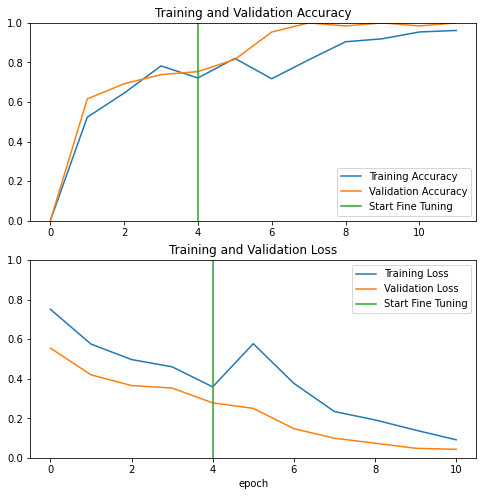

In [32]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

**What you should remember**:

* To adapt the classifier to new data: Delete the top layer, add a new classification layer, and train only on that layer
* When freezing layers, avoid keeping track of statistics (like in the batch normalization layer)
* Fine-tune the final layers of your model to capture high-level details near the end of the network and potentially improve accuracy 